In [1]:
import os
import random
import time

import imageio
import numpy as np
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils import data
from torchvision.transforms import transforms
import math
import multiprocessing as mp
import matplotlib.pyplot as plt

from utils.generate_bg import merge_by_mask
from utils.helpers import resize_to_128
from utils import configs, datasets, card_generator as card_gen

In [2]:
def add_coords_to_img(img_arr: np.array, coords: np.array) -> Image:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    draw = ImageDraw.Draw(image)
    for point in coords:
        px = point.item(0)
        py = point.item(1)
        d = img_arr.shape[0] * 0.015
        draw.ellipse((px - d, py - d, px + d, py + d), fill="red")
    return image

In [3]:
index = 0

In [4]:
card_img = Image.open(f'data/cards_pool/{index:0>4}.png')

In [5]:
card_img.mode

'RGBA'

In [6]:
card = np.array(card_img, dtype=np.uint8)

In [7]:
card.shape

(128, 128, 4)

In [8]:
card_size = (card.shape[0], card.shape[1])

# get coords

In [9]:
coords = datasets.get_orig_rectangle_coords(datasets.CARD_POSITION, datasets.CARD_SIZE)

In [10]:
ratio = float(configs.IMAGE_SIZE) / configs.ORIGINAL_SHAPE[0]
coords_128 = datasets.resize_coords(coords, ratio, configs.ORIGINAL_SHAPE, with_canvas=True)

In [11]:
coords_128

array([[ 24.72380952,  39.54285714],
       [101.56190476,  39.54285714],
       [ 24.72380952,  87.92380952],
       [101.56190476,  87.92380952]])

In [12]:
coords = np.copy(coords_128)

# make affine transformations

In [13]:
MAX_ANGLE = 45
MIN_RATIO = 0.7
card_len_x = coords_128.item(1,0) - coords_128.item(0,0)
card_len_y = coords_128.item(2,1) - coords_128.item(0,1)
MAX_RATIO = configs.IMAGE_SIZE / math.sqrt(card_len_x ** 2 + card_len_y ** 2)

In [14]:
MAX_RATIO

1.4096771451057375

In [15]:
MAX_RATIO = 1.2

In [16]:
theta = max(min(random.gauss(0, MAX_ANGLE / 3), MAX_ANGLE), -MAX_ANGLE)
coords = datasets.rotate_coords(coords, theta, card_size)
card = datasets.rotate_image(card, theta)

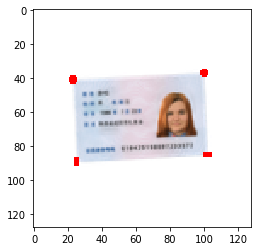

In [17]:
plt.imshow(add_coords_to_img(card, coords));

In [18]:
ratio = random.uniform(MIN_RATIO, MAX_RATIO)
coords = datasets.resize_coords(coords, ratio, card_size)
card = datasets.resize_image(card, ratio)

In [19]:
ratio

0.7530715887114183

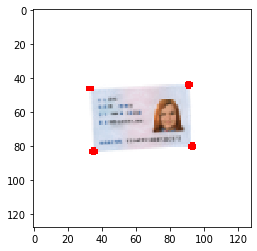

In [20]:
plt.imshow(add_coords_to_img(card, coords));

In [21]:
shift_x, shift_y = datasets.get_shift(coords, card_size)
coords = datasets.shift_coords(coords, shift_x, shift_y)
card = datasets.shift_image(card, shift_x, shift_y)

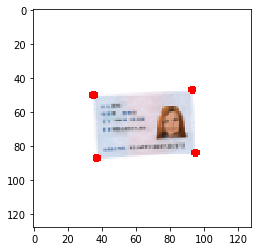

In [22]:
plt.imshow(add_coords_to_img(card, coords));

In [23]:
def get_card_with_affine(card, coords):
    
    theta = max(min(random.gauss(0, MAX_ANGLE / 3), MAX_ANGLE), -MAX_ANGLE)
    coords = datasets.rotate_coords(coords, theta, card_size)
    card = datasets.rotate_image(card, theta)
    
    ratio = random.uniform(MIN_RATIO, MAX_RATIO)
    coords = datasets.resize_coords(coords, ratio, card_size)
    card = datasets.resize_image(card, ratio)

    shift_x, shift_y = datasets.get_shift(coords, card_size)
    coords = datasets.shift_coords(coords, shift_x, shift_y)
    card = datasets.shift_image(card, shift_x, shift_y)
    
    return card, coords

In [24]:
card_img = Image.open(f'data/cards_pool/{index:0>4}.png')
card = np.array(card_img, dtype=np.uint8)
coords = np.copy(coords_128)

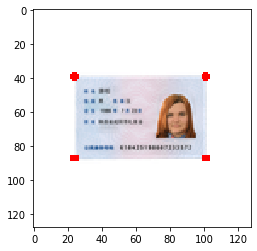

In [25]:
plt.imshow(add_coords_to_img(card, coords));

In [26]:
card, coords = get_card_with_affine(card, coords)

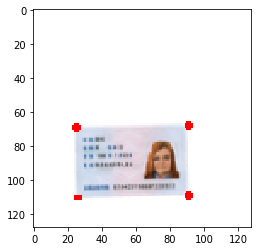

In [27]:
plt.imshow(add_coords_to_img(card, coords));

In [28]:
def get_sample():
    index = random.randint(0, 5000)
    card_img = Image.open(f'data/cards_pool/{index:0>4}.png')
    card = np.array(card_img, dtype=np.uint8)
    coords = np.copy(coords_128)
    card, coords = get_card_with_affine(card, coords)
    return card, coords

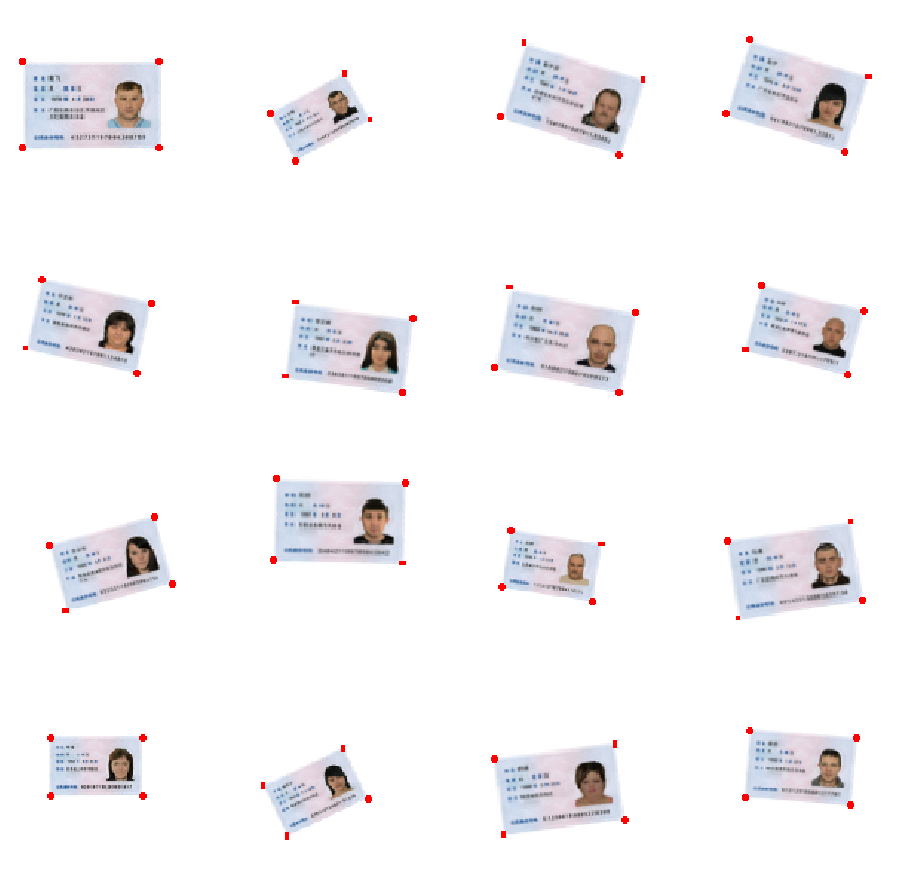

In [29]:
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
    for j in range(cols):
        card, coords = get_sample()
        axes[i, j].set_axis_off()
        axes[i, j].imshow(add_coords_to_img(card, coords));

# admix GI background

In [30]:
gi_bg = datasets.get_gi_bg()

In [31]:
gi_bg.shape

(128, 128, 3)

In [32]:
card, coords = get_sample()

In [33]:
sample = Image.alpha_composite(
    Image.fromarray(gi_bg, 'RGB').convert('RGBA'), 
    Image.fromarray(card, 'RGBA')
)

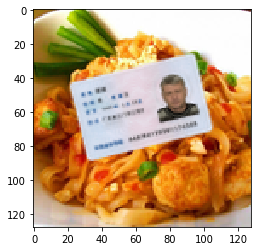

In [34]:
plt.imshow(sample);

In [35]:
def get_sample():
    index = random.randint(0, 5000)
    card_img = Image.open(f'data/cards_pool/{index:0>4}.png')
    card = np.array(card_img, dtype=np.uint8)
    coords = np.copy(coords_128)
    card, coords = get_card_with_affine(card, coords)
    gi_bg = datasets.get_gi_bg()
    sample = Image.alpha_composite(
        Image.fromarray(gi_bg, 'RGB').convert('RGBA'), 
        Image.fromarray(card, 'RGBA')
    )
    return np.array(sample), coords

CPU times: user 481 ms, sys: 120 ms, total: 602 ms
Wall time: 600 ms


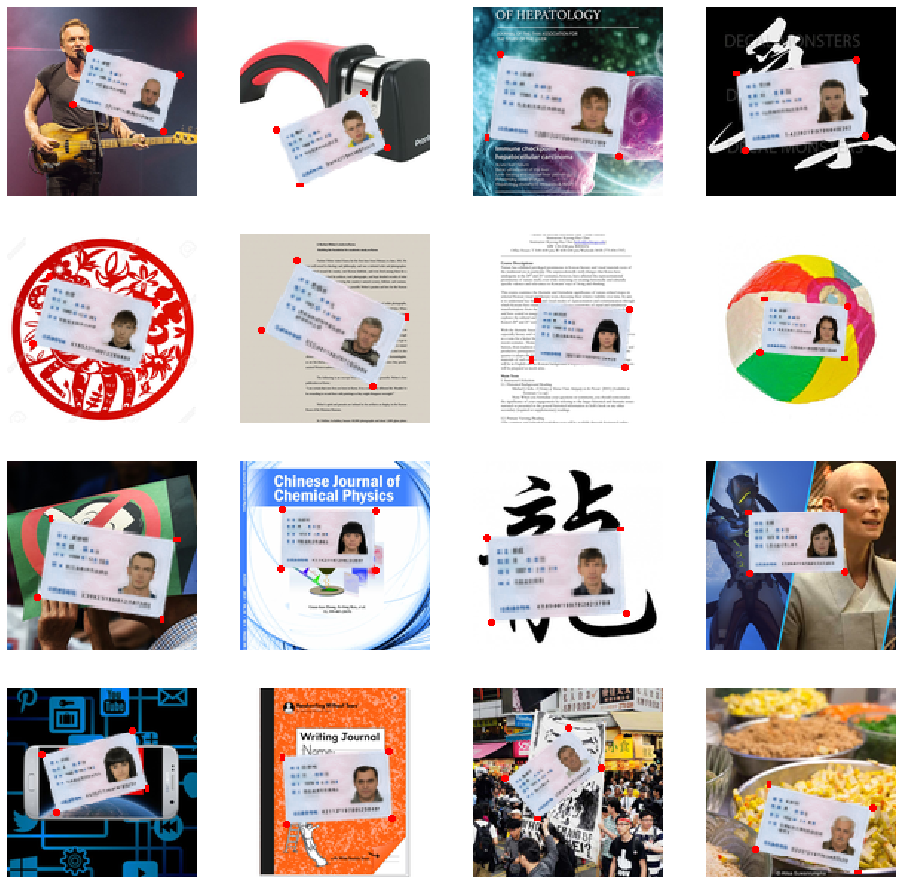

In [36]:
%%time
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
    for j in range(cols):
        card, coords = get_sample()
        axes[i, j].set_axis_off()
        axes[i, j].imshow(add_coords_to_img(card, coords));

# GENERATE DATASET

In [37]:
def get_sample(gi_index: int = None):
    # get random card
    index = random.randint(0, 267 * 20 - 1)
    card_img = Image.open(f'data/cards_pool/{index:0>4}.png')
    card = np.array(card_img, dtype=np.uint8)
    coords = np.copy(coords_128)
    # make affine transformations
    card, coords = get_card_with_affine(card, coords)
    # add backround
    gi_bg = datasets.get_gi_bg(index=gi_index)
    sample = Image.alpha_composite(
        Image.fromarray(gi_bg, 'RGB').convert('RGBA'), 
        Image.fromarray(card, 'RGBA')
    )
    return np.array(sample.convert('RGB')), coords

In [38]:
def save_img(img_arr: np.array, filename):
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    image.save(filename)

In [39]:
gi_filenames = os.listdir('./data/images')
len(gi_filenames)

14417

In [40]:
GI_BG_COUNT = len(gi_filenames)

In [41]:
def save_sample(index):
    sample, coords = get_sample(gi_index=index % GI_BG_COUNT)
    save_img(sample, f'data/trainset_128/{index:0>7}.png')
    np.savetxt(f'data/trainset_128/{index:0>7}.csv', coords, delimiter=",", fmt='%1.3f')

In [42]:
gi_filenames = os.listdir('./data/images')
with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.map(save_sample, list(range(GI_BG_COUNT * 4)))

/home/sdlm/.local/share/virtualenvs/chinese-ausweis-viewer-t8v6qUJl/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/home/sdlm/.local/share/virtualenvs/chinese-ausweis-viewer-t8v6qUJl/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/home/sdlm/.local/share/virtualenvs/chinese-ausweis-viewer-t8v6qUJl/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/home/sdlm/.local/share/virtualenvs/chinese-ausweis-viewer-t8v6qUJl/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to re